The travelling salesman problem is a famous problem in computer science. It was stated by William Rowan Hamilton, who is most famous for his contributions to optics, mechanics and algebra, notably for the invention of quaternions.



In [2]:
import matplotlib.pyplot as ply
%matplotlib inline

import networkx as nx
import numpy as np

from qiskit.optimization.applications.ising import tsp
from qiskit.aqua.input import EnergyInput
from qiskit.aqua import run_algorithm
from qiskit_qcgpu_provider import QCGPUProvider

ModuleNotFoundError: No module named 'qiskit.aqua.input'

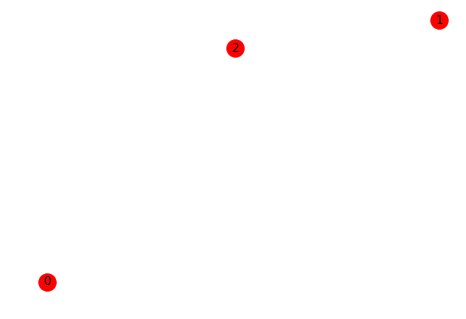

In [4]:
locations = 3

problem = tsp.random_tsp(locations)
positions = {k: v for k, v in enumerate(problem.coord)}

G = nx.Graph()
G.add_nodes_from(np.arange(0, locations, 1))
nx.draw(G, with_labels=True, pos=positions)

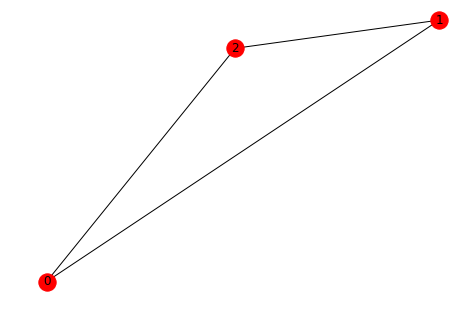

In [5]:
best_distance, best_order = brute_force(problem.w, problem.dim)
draw(G, best_order, positions)

# Solving Using The Variational Quantum Eigensolver

In [6]:
operator, offset = tsp.get_tsp_qubitops(problem)
algorithm_input = EnergyInput(operator)

algorithm_parameters = {
    'problem': { 'name': 'ising', 'random_seed': 23 },
    'algorithm': { 'name': 'VQE', 'operator_mode': 'matrix' },
    'optimizer': { 'name': 'SPSA', 'max_trials':100 },
    'variational_form': {'name': 'RY', 'depth': 5, 'entanglement': 'linear'}
}

In [7]:
backend = QCGPUProvider().get_backend('statevector_simulator')
%time result_qiskit = run_algorithm(algorithm_parameters, algorithm_input)
%time result = run_algorithm(algorithm_parameters, algorithm_input, backend=backend)


CPU times: user 32.1 s, sys: 127 ms, total: 32.3 s
Wall time: 36.8 s
CPU times: user 22.9 s, sys: 241 ms, total: 23.1 s
Wall time: 23.1 s


Look at that! It completed it 13 seconds quicker, just by using the GPU!

feasible: True
solution: [2, 1, 0]
solution objective: 203.0


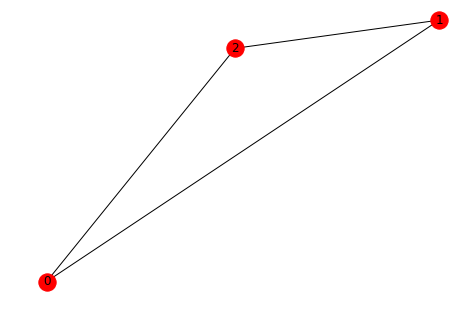

In [8]:
#print('tsp objective:', result['energy'] + offset)
x = tsp.sample_most_likely(result['eigvecs'][0])
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, problem.w))
draw(G, z, positions)

In [1]:
# Utitlity Functions
def draw(G, order, positions):
    G2 = G.copy()
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j])
    nx.draw(G2, pos=positions, with_labels=True)
    
# Classically solve the problem using a brute-force method
from itertools import permutations

def brute_force(weights, N):
    a = list(permutations(range(1, N)))
    best_distance = None
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance += weights[j, pre_j]
            pre_j = j
        distance += weights[pre_j, 0]
        order = (0,) + i
        if best_distance is None or distance < best_distance:
            best_order = order
            best_distance = distance
            
    return best_distance, best_order

In [2]:
import warnings
warnings.filterwarnings('ignore')

# NEW VERSION:


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import networkx as nx
import numpy as np

from qiskit_optimization.applications import Tsp

from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp


In [3]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

distance
 [[ 0. 15. 62.]
 [15.  0. 58.]
 [62. 58.  0.]]


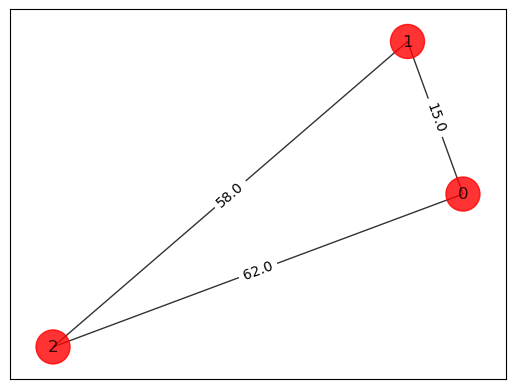

In [4]:
locations = 3

tsp = Tsp.create_random_instance(locations)
# positions = {k: v for k, v in enumerate(problem.)}

# G = nx.Graph()
# G.add_nodes_from(np.arange(0, locations, 1))
# nx.draw(G, with_labels=True, pos=positions)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

In [7]:
from qiskit_optimization.converters import QuadraticProgramToQubo


# se transforma el problema de travelling salesman a formato cuadratico
quadratic_tsp = tsp.to_quadratic_program()
# se transforma el formato cuadratico en un un Qubo
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(quadratic_tsp)
#transformamos el qubo en un input de algoritmo para poder introducirlo en el backend
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 5068.5
Ising Hamiltonian:
-849.5 * IIIIIIIIZ
- 849.5 * IIIIIIIZI
- 849.5 * IIIIIIZII
- 847.5 * IIIIIZIII
- 847.5 * IIIIZIIII
- 847.5 * IIIZIIIII
- 871.0 * IIZIIIIII
- 871.0 * IZIIIIIII
- 871.0 * ZIIIIIIII
+ 405.5 * IIIIIIIZZ
+ 405.5 * IIIIIIZIZ
+ 405.5 * IIIIIIZZI
+ 405.5 * IIIIIZIIZ
+ 3.75 * IIIIIZIZI
+ 3.75 * IIIIIZZII
+ 3.75 * IIIIZIIIZ
+ 405.5 * IIIIZIIZI
+ 3.75 * IIIIZIZII
+ 405.5 * IIIIZZIII
+ 3.75 * IIIZIIIIZ
+ 3.75 * IIIZIIIZI
+ 405.5 * IIIZIIZII
+ 405.5 * IIIZIZIII
+ 405.5 * IIIZZIIII
+ 405.5 * IIZIIIIIZ
+ 15.5 * IIZIIIIZI
+ 15.5 * IIZIIIZII
+ 405.5 * IIZIIZIII
+ 14.5 * IIZIZIIII
+ 14.5 * IIZZIIIII
+ 15.5 * IZIIIIIIZ
+ 405.5 * IZIIIIIZI
+ 15.5 * IZIIIIZII
+ 14.5 * IZIIIZIII
+ 405.5 * IZIIZIIII
+ 14.5 * IZIZIIIII
+ 405.5 * IZZIIIIII
+ 15.5 * ZIIIIIIIZ
+ 15.5 * ZIIIIIIZI
+ 405.5 * ZIIIIIZII
+ 14.5 * ZIIIIZIII
+ 14.5 * ZIIIZIIII
+ 405.5 * ZIIZIIIII
+ 405.5 * ZIZIIIIII
+ 405.5 * ZZIIIIIII


In [1]:
# PREPARING THE QISKIT BACKEND
from qiskit_ibm_runtime import QiskitRuntimeService
IBM_QX_API_TOKEN = 'a998d08dcbe837698586eebef6b0bd5f6edb78e05a74cdd944ace2636e41329ffa39585a8f923c4145d02caf3931e2fd9c9b788164a7d0097795289c931ef872'

# Save an IBM Quantum account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token=IBM_QX_API_TOKEN, overwrite=True)

service = QiskitRuntimeService(channel="ibm_quantum")

# Get the backend
backend = service.get_backend("ibmq_qasm_simulator")
%time result_qiskit = run_algorithm(algorithm_parameters, algorithm_input)
%time result = run_algorithm(algorithm_parameters, algorithm_input, backend=backend)

KeyboardInterrupt: 